Acurácia média no treino (CV): 0.5586
Acurácia final no conjunto de validação: 0.5238

Matriz de confusão - Treino:
[[ 816 2081]
 [ 620 2736]]

Matriz de confusão - Validação:
[[494 594]
 [348 542]]


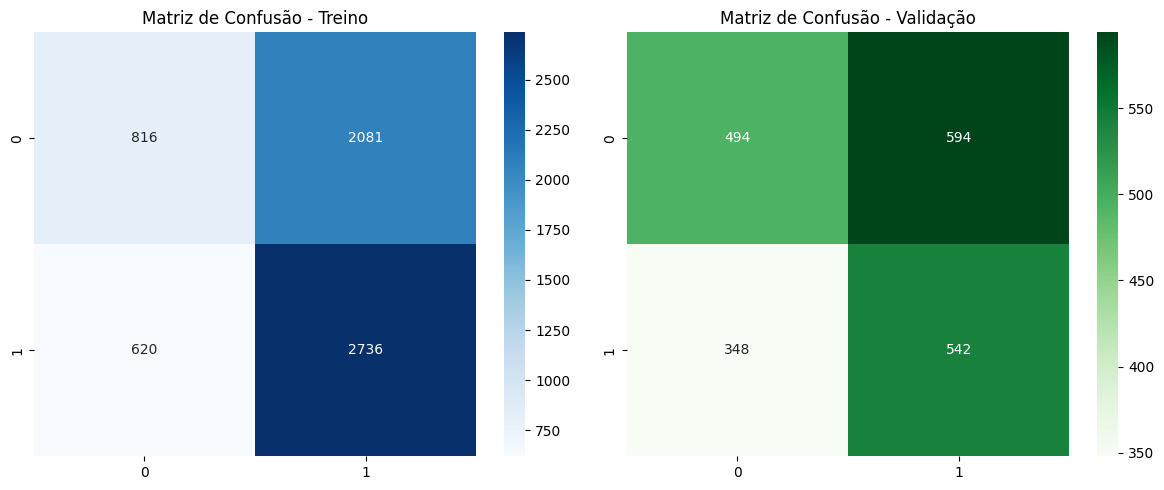

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('candles_previstos_como_1.csv', parse_dates=['date'])

train_start, train_end = '2024-01-01', '2024-03-30'
test_start, test_end = '2024-04-01', '2024-06-30'

treino = df[(df['date'] >= train_start) & (df['date'] <= train_end)]
validacao = df[(df['date'] >= test_start) & (df['date'] <= test_end)]

for df in [treino, validacao]:
    df.drop(columns=['date'], inplace=True)
    
X_train = treino.drop(columns=['trend'])  
y_train = treino['trend']  

X_valid = validacao.drop(columns=['trend'])  
y_valid = validacao['trend'] 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)


skf = StratifiedKFold(n_splits=9, shuffle=True, random_state=42)

train_preds = np.zeros(len(X_train))
val_preds = np.zeros(len(X_valid))  

train_scores = []
val_scores = []

for train_idx, val_idx in skf.split(X_train_scaled, y_train):
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    mlp = MLPClassifier(
        hidden_layer_sizes=(32, 16),  
        activation='tanh',            
        learning_rate_init=0.1,    
        max_iter=10000,                
        early_stopping=True,          
        random_state=42
    )

    mlp.fit(X_tr, y_tr)

    y_tr_pred = mlp.predict(X_tr)
    y_val_pred = mlp.predict(X_val)

    train_scores.append(accuracy_score(y_tr, y_tr_pred))
    val_scores.append(accuracy_score(y_val, y_val_pred))

    train_preds[train_idx] = y_tr_pred

final_model = MLPClassifier(
        hidden_layer_sizes=(32, 16), 
        activation='tanh',            
        alpha=0.001,                  
        learning_rate_init=0.1,     
        max_iter=10000,                
        early_stopping=True,         
        random_state=42
    )
final_model.fit(X_train_scaled, y_train)
val_preds = final_model.predict(X_valid_scaled)

# Resultados
print(f"Acurácia média no treino (CV): {np.mean(train_scores):.4f}")
print(f"Acurácia final no conjunto de validação: {accuracy_score(y_valid, val_preds):.4f}")

print("\nMatriz de confusão - Treino:")
print(confusion_matrix(y_train, train_preds))

print("\nMatriz de confusão - Validação:")
print(confusion_matrix(y_valid, val_preds))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_train, train_preds), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Matriz de Confusão - Treino")
sns.heatmap(confusion_matrix(y_valid, val_preds), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("Matriz de Confusão - Validação")

plt.tight_layout()
plt.show()
